## Imports and Installs

In [1]:
import platform
platform.platform()

'macOS-12.4-arm64-i386-64bit'

In [2]:
import torch

torch.has_mps

True

In [3]:
import pandas as pd
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

from transformers import BertTokenizer
from transformers import BertModel

In [4]:
train_data_path = 'Data/BF_Subject_Clean_Call_Number.csv'
df = pd.read_csv(train_data_path, sep='\t')
df = df.drop("Unnamed: 0", axis=1)

df.head()

,Title,Call_Number
0,jung c g carl gustav 18751961 psychoanalysis,174
1,witchcraft germany braunschweig region demon...,1583
2,psychology qualitative research ethnology me...,76.5
3,selling psychology applied,636
4,associations institutions etc stress psycholog...,175.5


In [6]:
vals = pd.unique(df['Call_Number'])
print(len(vals))
labels = {value: key for (key, value) in enumerate(vals)}
print(labels)

658
{'174': 0, '1583': 1, '76.5': 2, '636': 3, '175.5': 4, '121': 5, '723': 6, '1598': 7, '210': 8, '870': 9, '711': 10, '698.5': 11, '201': 12, '323': 13, '311': 14, '713': 15, '319': 16, '431': 17, '176': 18, '637': 19, '18.02': 20, '175': 21, '633': 22, '632.5': 23, '1576': 24, '173': 25, '710': 26, '698': 27, '378': 28, '697': 29, '1325': 30, '408': 31, '432': 32, '113': 33, '325': 34, '448': 35, '639': 36, '295': 37, '371': 38, '207': 39, '721': 40, '1593': 41, '692.2': 42, '1407': 43, '724': 44, '575': 45, '318': 46, '1779': 47, '341': 48, '1999': 49, '692.5': 50, '162': 51, '39': 52, '321': 53, '441': 54, '38': 55, '714': 56, '1622': 57, '447': 58, '109': 59, '76.4': 60, '1791': 61, '241': 62, '1611': 63, '698.3': 64, '316.6': 65, '1561': 66, '105': 67, '315': 68, '701': 69, '335': 70, '698.95': 71, '455': 72, '1793': 73, '201.3': 74, '38.5': 75, '724.3': 76, '1434': 77, '233': 78, '774': 79, '720': 80, '717': 81, '458': 82, '531': 83, '81': 84, '31': 85, '1591': 86, '39.9': 87,

## Create Dataset from Training Data file

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

class Dataset(torch.utils.data.Dataset):
  def __init__(self, df):
    self.labels = [labels[label] for label in df['Call_Number']]

    self.texts = [tokenizer(text,
                            padding='max_length',max_length=512, truncation=True,
                            return_tensors="pt") for text in df['Title']]

  def __len__(self):
      return len(self.labels)

  def __getitem__(self, idx):
    batch_texts = self.get_batch_texts(idx)
    batch_y = self.get_batch_labels(idx)

    return batch_texts, batch_y
  def classes(self):
    return self.labels

  def get_batch_labels(self, idx):
    return np.array(self.labels[idx])

  def get_batch_texts(self, idx):
    return self.texts[idx]

In [8]:
np.random.seed(112)
rand = np.random.randint(1,high=100)
print(rand)

df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=rand),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

44
15074 1884 1885


## Load BERT Model

In [9]:
class BertClassifier(nn.Module):
  def __init__(self, dropout=0.5):
    super(BertClassifier, self).__init__()

    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(768, len(vals)) # Change depending on dataset size
    self.relu = nn.ReLU()

  def forward(self, input_id, mask):
    _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask, return_dict=False)
    dropout_output = self.dropout(pooled_output)
    linear_output = self.linear(dropout_output)
    final_layer = self.relu(linear_output)

    return final_layer

## Train Model

In [10]:
def train(model, train_data, val_data, learning_rate, epoch):
  training_dataset, val_dataset = Dataset(train_data), Dataset(val_data)


  train_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=8, shuffle=True)
  val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8)

  
  if torch.has_mps:
    device = torch.device("mps")
  else:
    device = torch.device("cpu")

  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = Adam(model.parameters(), lr=learning_rate)
  

  # Results array to store values
  results = []
  all_train_loss = []
  all_val_loss = []
  all_train_acc = []
  all_val_acc = []

  #prev_val_acc = 0

  model.to(device)
  
  for epoch_num in range(epoch):
    print(f"Epoch # {epoch_num+1}/{epoch}")

    total_acc_train = 0
    total_loss_train = 0

    for train_input, train_label in tqdm(train_dataloader):

      train_label = train_label.to(device)
      mask = train_input['attention_mask'].to(device)
      input_id = train_input['input_ids'].squeeze(1).to(device)


      output = model(input_id, mask)

      batch_loss = criterion(output, train_label)
      total_loss_train += batch_loss.item()

      acc = (output.argmax(dim=1) == train_label).sum().item()
      total_acc_train += acc

      model.zero_grad()
      batch_loss.backward()
      optimizer.step()

    
    total_acc_val = 0
    total_loss_val = 0

    with torch.no_grad():
      for val_input, val_label in val_dataloader:
        val_label = val_label.to(device)

        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)

        batch_loss = criterion(output, val_label)
        total_loss_val += batch_loss.item()

        acc = (output.argmax(dim=1) == val_label).sum().item()
        total_acc_val += acc

        # Add values to respective result array
        all_train_loss.append(total_loss_train / len(train_data))
        all_train_acc.append(total_acc_train / len(train_data))
        all_val_loss.append(total_loss_val / len(val_data))
        all_val_acc.append(total_acc_val / len(val_data))

    print(
        f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
        | Train Accuracy: {total_acc_train / len(train_data): .3f} \
        | Val Loss: {total_loss_val / len(val_data): .3f} \
        | Val Accuracy: {total_acc_val / len(val_data): .3f}')
    '''
    if prev_val_acc > total_acc_val / len(val_data):
      print("Breaking early because validation accuracy has decreased")
      break
    else:
      prev_val_acc = total_acc_val / len(val_data)
    '''

  # Append result arrays to full array
  results.append(all_train_loss)
  results.append(all_train_acc)
  results.append(all_val_loss)
  results.append(all_val_acc)

  return model, results

In [11]:
if 'model' in locals():
  del model

model = BertClassifier()
LR = 1e-6
EPOCHS = 5
model, training_results = train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch # 1/5


100%|██████████| 1885/1885 [22:55<00:00,  1.37it/s]


Epochs: 1 | Train Loss:  0.781         | Train Accuracy:  0.037         | Val Loss:  0.727         | Val Accuracy:  0.072
Epoch # 2/5


  1%|▏         | 25/1885 [00:18<23:16,  1.33it/s]


KeyboardInterrupt: 

: 

In [ ]:
def evaluate(model, test_data):
  test = dataset(test_data)

  test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  if use_cuda:
    model = model.cuda()

  total_acc_test = 0

  with torch.no_grad():
    for test_input, test_label in test_dataloader:
      test_label = test_label.to(device)
      mask= test_input['attention_mask'].to(device)
      input_id = test_input['input_ids'].squeeze(1).to(device)

      output = model(input_id, mask)

      acc = (output.argmax(dim=1) == test_label).sum().item()

      total_acc_test += acc
  
  print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')


evaluate(model, df_test)

# Save Model to Models Folder

In [ ]:
torch.save(model.state_dict(), "Models/BERT_Classifier_20_epoch_subjects_only.pt")

In [22]:
load_model = BertClassifier()
load_model.load_state_dict(torch.load("Models/BERT_Classifier_20_epoch_subjects_only.pt", map_location=torch.device('cpu')))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

## Generate Visualizations for Results

In [2]:
train_loss = [2.883, 2.321, 1.971, 1.749, 1.578, 1.443, 1.337, 1.242, 1.161, 1.091, 1.028, 0.973, 0.923, 0.877, 0.836, 0.797, 0.761, 0.728, 0.700, 0.672, 0.647, 0.623, 0.601, 0.581, 0.561]
train_acc = [0.144, 0.300, 0.416, 0.492, 0.543, 0.583, 0.613, 0.645, 0.671, 0.694, 0.712, 0.728, 0.741, 0.753, 0.762, 0.774, 0.783, 0.792, 0.801, 0.805, 0.811, 0.819, 0.824, 0.828, 0.834]
val_loss= [2.563, 2.111, 1.857, 1.690, 1.544, 1.458, 1.362, 1.302, 1.246, 1.204, 1.153, 1.126, 1.091, 1.065, 1.048, 1.024, 0.998, 0.992, 0.975, 0.962, 0.948, 0.939, 0.929, 0.921, 0.914]
val_acc = [0.246, 0.373, 0.477, 0.523, 0.553, 0.574, 0.597, 0.616, 0.639, 0.639, 0.656, 0.670, 0.671, 0.668, 0.686, 0.689, 0.688, 0.690, 0.699, 0.697, 0.703, 0.705, 0.708, 0.712, 0.698]
epochs = [i for i in range(1, 26)]

In [9]:
line1 = zip(epochs, train_acc)

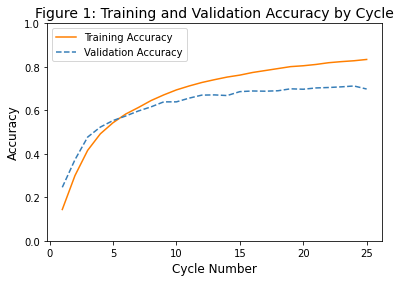

In [8]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_acc,'-', color='#ff7f00', label="Training Accuracy")
plt.plot(epochs, val_acc,'--', color='#377eb8',  label="Validation Accuracy")
plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0])
plt.title("Figure 1: Training and Validation Accuracy by Cycle", fontsize=14)
plt.xlabel("Cycle Number", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.savefig('Images/accuracy.png')
plt.show()


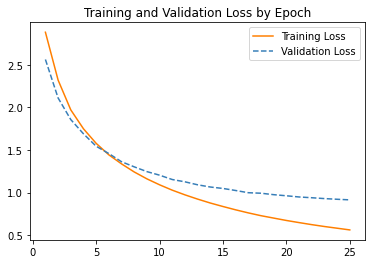

In [33]:
import matplotlib.pyplot as plt


plt.plot(epochs, train_loss,'-', color='#ff7f00', label="Training Loss")
plt.plot(epochs, val_loss, '--', color='#377eb8',  label="Validation Loss")
plt.title("Training and Validation Loss by Epoch")
plt.legend()
plt.savefig('Images/loss.png')
plt.show()